# 3. Machine Learning for Classification

In [1]:
import pandas as pd
import numpy as np

## 3.1 Data preparation 

In [2]:
# !wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')

In [4]:
active_cols = ['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
df = df[active_cols]
df = df.fillna(0)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

## 3.2 Exploratory Data Analysis 

### Question 1: Most frequent value for neighbourhood_group 

In [6]:
df.neighbourhood_group.describe()

count         48895
unique            5
top       manhattan
freq          21661
Name: neighbourhood_group, dtype: object

In [7]:
df.neighbourhood_group.mode()

0    manhattan
dtype: object

## 3.3 Setting up the validation framework 

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [10]:
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_df_full_train = df_full_train.price.values
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [13]:
del df_full_train['price']
del df_train['price']
del df_val['price']
del df_test['price']

## 3.4 Feature importance: Correlation

In [14]:
from IPython.display import display
import seaborn as sn
import matplotlib.pyplot as plt

In [15]:
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

corrMatrix = df_full_train[numerical].corr()

display(corrMatrix)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.080704,0.025497,-0.011836,-0.013809,0.020299,-0.008341
longitude,0.080704,1.000000,-0.063498,0.057570,0.134401,-0.115289,0.082994
minimum_nights,0.025497,-0.063498,1.000000,-0.077860,-0.121687,0.121748,0.140596
number_of_reviews,-0.011836,0.057570,-0.077860,1.000000,0.584935,-0.072603,0.175428
reviews_per_month,-0.013809,0.134401,-0.121687,0.584935,1.000000,-0.047368,0.165565
calculated_host_listings_count,0.020299,-0.115289,0.121748,-0.072603,-0.047368,1.000000,0.223328
availability_365,-0.008341,0.082994,0.140596,0.175428,0.165565,0.223328,1.000000


### Question 2: Features with biggest correlation

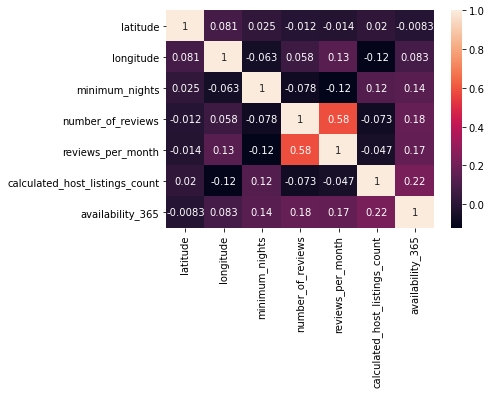

In [16]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

## 3.5 Feature importance: Mutual information

In [17]:
def above_average(a_series, average):
    return (a_series >= average).astype(int)

y_df_full_train = above_average(y_df_full_train, 152)

In [18]:
y_train_log = above_average(y_train, 152)
y_val_log = above_average(y_val, 152)
y_test_log = above_average(y_test, 152)

In [19]:
from sklearn.metrics import mutual_info_score

In [20]:
categorical = ['neighbourhood_group', 'room_type']
for col in categorical:
    score = mutual_info_score(y_df_full_train, df_full_train[col])
    print(col, "\t", round(score,2))

neighbourhood_group 	 0.05
room_type 	 0.14


### Question 3: Which variable has the highest mutual information?

In [21]:
def mutual_info_score_df(series):
    return round(mutual_info_score(series, y_df_full_train),2)

In [22]:
mi = df_full_train[categorical].apply(mutual_info_score_df)
mi.sort_values(ascending=False)

room_type              0.14
neighbourhood_group    0.05
dtype: float64

## 3.6 One-hot encoding

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## 3.7 Training logistic regression with Scikit-Learn

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
model = LogisticRegression(solver="liblinear", C=1.0, random_state=42)

In [27]:
model.fit(X_train, y_train_log)

LogisticRegression(random_state=42, solver='liblinear')

### Question 4: Accuracy of the model 

In [28]:
def accuracy(model, X_val, y_val):
    y_pred = model.predict_proba(X_val)[:, 1]
    decision = (y_pred >= 0.5)
    
    df_pred = pd.DataFrame()
    df_pred['probability'] = y_pred
    df_pred['prediction'] = decision.astype(int)
    df_pred['actual'] = y_val
    
    df_pred['correct'] = df_pred.prediction == df_pred.actual
    return df_pred.correct.mean()

In [29]:
gen_accuracy = accuracy(model, X_val, y_val_log)
print(round(gen_accuracy, 2))

0.79


In [30]:
from sklearn.feature_extraction import DictVectorizer

def vectorized_features(df_train, df_val):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return X_train, X_val

def eliminate_train_diff_accuracy(df_train, df_val, y_train, y_val, col_to_eliminate, an_accuracy):
    df_train_1 = df_train.drop([col_to_eliminate], axis=1)
    df_val_1 = df_val.drop([col_to_eliminate], axis=1)
    
    X_train, X_val = vectorized_features(df_train_1, df_val_1)
    
    model = LogisticRegression(solver="liblinear", C=1.0, random_state=42)
    model.fit(X_train, y_train)
    
    acc = accuracy(model, X_val, y_val)
    diff = round((an_accuracy - acc), 6)
    print(col_to_eliminate, "\t", acc, "\t", diff)

### Question 5: Feature selection - the smallest difference in accuracy 

In [31]:
cols = ['neighbourhood_group', 'room_type', 'number_of_reviews', 'reviews_per_month']
for col in cols:
    eliminate_train_diff_accuracy(df_train, df_val, y_train_log, y_val_log, col, gen_accuracy)
    

neighbourhood_group 	 0.7498721750690255 	 0.039063
room_type 	 0.7295224460578791 	 0.059413
number_of_reviews 	 0.7913897126495552 	 -0.002454
reviews_per_month 	 0.7907761529808774 	 -0.001841


### Question 6: Regression with Scikit-Learn. What's the best alpha? 

In [32]:
y_train_r = np.log1p(y_train)
y_val_r = np.log1p(y_val)
y_test_r = np.log1p(y_test)

In [33]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def train_and_validate_linear_regression_model(df_train, df_val, y_train_r, y_val_r, alp):
    X_train, X_val = vectorized_features(df_train, df_val)
    
    model = Ridge(alpha=alp)    
    model.fit(X_train, y_train_r) 

    y_pred= model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val_r, y_pred))
    print(alp, "\t", round(rmse,3)) 
    


In [34]:
for alp in [0, 0.01, 0.1, 1, 10]:
    train_and_validate_linear_regression_model(df_train, df_val, y_train_r, y_val_r, alp)

0 	 0.497
0.01 	 0.497
0.1 	 0.497
1 	 0.497
10 	 0.498
